# Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import string
import spacy
np.random.seed(42)
from tqdm.notebook import tqdm
import dateparser
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [34]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation
to_remove = ['urllink', 'jpg', 'nbsp', 'http', 'www']

# Cleaning functions

In [ ]:
def clean_and_transform(data):
    # remove rows without topic and date and reset index
    data = data.loc[data['topic']!='indUnk',:]
    data = data.dropna()
    data = data.reset_index(drop = True)

    # create column for word count
    data.loc[:,'word_count'] = data.loc[:,'text'].apply(lambda x: len(x.split()))

    # create unique id for each blog
    data.loc[:, 'blog_id'] = data.index.astype(str)
    data.loc[:, 'blog_id'] = data.blog_id.apply(lambda x : '1'+x.zfill(6))

    # clean up the date in multiple language
    for ind, row in data.iterrows():
        try:
            date_raw = row['date']
            clean_date = dateparser.parse(date_raw)
            data.loc[ind,'date_clean'] = clean_date
        except Exception as e:
            print(ind, e)

    # after cleaning there're extra rows for data after 2004, remove those
    data = data.loc[data['date_clean']<'2005-01-01',:]

    # rename and arrange the columns
    data_clean = data.rename(columns = {'id':'author_id', 'date':'date_raw', 'date_clean': 'date','topic':'occupation'})
    data_clean = data_clean.loc[:,['author_id', 'gender', 'age','occupation', 'sign', 'blog_id','date','text', 'word_count']]

    return data_clean

In [ ]:
def clean_text(sentence):
    import re
    # create token object
    doc = nlp(sentence)

    mytokens = [word.lemma_.lower().strip() for word in doc] # lemmatize token and convert into lower case
    mytokens = [re.sub(r'\W+',' ',token) for token in mytokens] # replace everything non-alpahnumeric by ' '
    mytokens = [re.sub(r'\s+',' ',token) for token in mytokens] # replace one or more whitespaces by  ' '
    mytokens = [re.sub(r'\d+',' ',token) for token in mytokens] # replace one or more digits by ' '
    
    # remove stopwords, punctuation and empty string
    mytokens = [word.strip() for word in mytokens if word not in stop_words 
                and word not in punctuations and word not in to_remove and len(word) > 1]
    mytokens = [word for word in mytokens if word]
    clean_text = " ".join(mytokens)
    return clean_text

In [487]:
data_raw = pd.read_csv('blogtext.csv')
data_raw.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
data = clean_and_transform(data_raw)
data.to_csv('blog_author_clean.csv', index = False) # export cleaned data as csv (text not cleaned yet)

In [ ]:
data.loc[:,'clean_text'] = data['text'].apply(clean_text)

In [ ]:
data.to_csv('cleaned_text_dump.csv', index=False)

# EDA

In [523]:
data = pd.read_csv('cleaned_text_dump.csv')
print(data.shape)
data.head()

(430218, 13)


,author_id,gender,age,occupation,sign,blog_id,date,text,word_count,year,clean_text,label_all,gender_age
0,2059027,male,15,Student,Leo,1000000,2004-05-14,"Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.",28,2004,info find page mb pdf file wait untill team leader process learn html,"['male', '15', 'Student', 'Leo']","['male', '15']"
1,2059027,male,15,Student,Leo,1000001,2004-05-13,These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie urlLink mail Bryan Aaldering (me) urlLink mail,20,2004,team member drewes van der laag urllink mail ruiyu xie urllink mail bryan aaldering urllink mail,"['male', '15', 'Student', 'Leo']","['male', '15']"
2,2059027,male,15,Student,Leo,1000002,2004-05-12,"In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-Bomb From: ascott@tartarus.uwa.edu.au (Andrew Scott) Newsgroups: rec.humor Subject: How To Build An H-Bomb (humorous!) Date: 7 Feb 1994 07:41:14 GMT Organization: The University of Western Australia Original file dated 12th November 1990. Seemed to be a transcript of a 'Seven Days' article. Poorly formatted and corrupted. I have added the text between 'examine under a microscope' and 'malleable, ...",4326,2004,het kader van kernfusie op aarde maak je eigen waterstofbom build h bomb ascott tartarus uwa edu au andrew scott newsgroups rec humor subject build h bomb humorous date feb gmt organization university western australia original file date th november transcript seven day article poorly format corrupt add text examine microscope malleable like gold miss text distribute responsible accuracy information convert html dionisio infinet com little spell checking minor edit steal urllink http my ohio...,"['male', '15', 'Student', 'Leo']","['male', '15']"
3,2059027,male,15,Student,Leo,1000003,2004-05-12,testing!!! testing!!!,2,2004,testing testing,"['male', '15', 'Student', 'Leo']","['male', '15']"
4,3581210,male,33,InvestmentBanking,Aquarius,1000004,2004-06-11,"Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now I can show you some cool links to Korean Pop (K-Pop) audio and video without the need to relate instructions like: 'go to the site, click on the pop-audio button then choose...'. So, without further ado here is the link to 24-hour K-Pop urlLink audio and the urlLink video streaming. Enjoy.",65,2004,thank yahoo s toolbar capture url popup mean cool link korean pop k pop audio video need relate instruction like site click pop audio button choose ado link hour k pop urllink audio urllink video streaming enjoy,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']"


In [339]:
authors = data.loc[:, ['id','gender','age','topic','sign']].drop_duplicates()
authors.head()

,id,gender,age,topic,sign
0,2059027,male,15,Student,Leo
4,3581210,male,33,InvestmentBanking,Aquarius
74,3539003,female,14,indUnk,Aries
95,4172416,female,25,indUnk,Capricorn
97,3668238,female,17,Student,Gemini


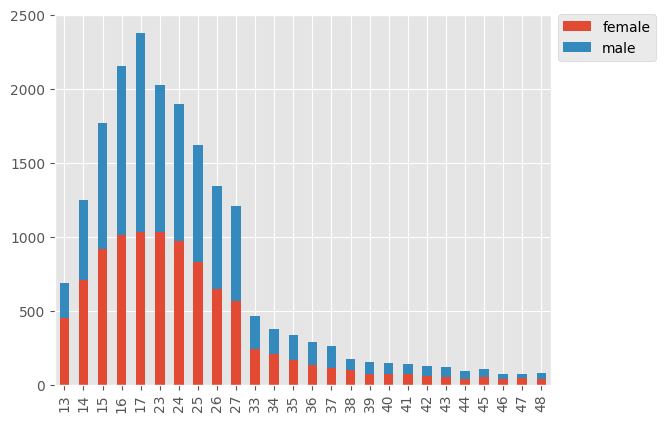

In [341]:
age_gender = authors.pivot_table(index = 'age', columns = 'gender',values = 'id', aggfunc='count')
age_gender.plot(kind='bar', stacked=True)
plt.xlabel('')
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )

<AxesSubplot: ylabel='topic'>

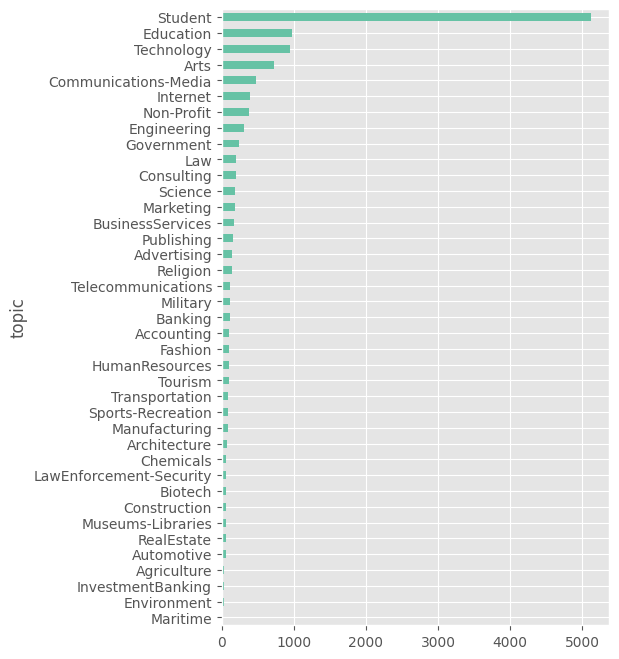

In [490]:
occupation = data_raw[data_raw['topic']!='indUnk']
occupation = occupation.groupby('topic')['id'].nunique()
occupation.sort_values().plot(kind='barh', figsize=(5,8), colormap='Set2')

<AxesSubplot: xlabel='sign'>

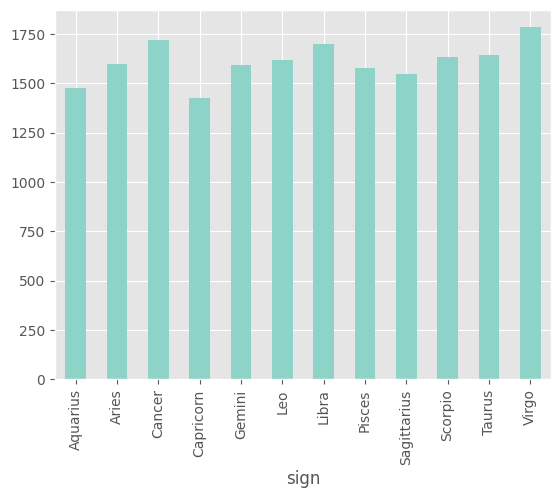

In [343]:
zodiac = data.groupby('sign')['id'].nunique()
zodiac.plot(kind='bar', colormap='Set3')

In [ ]:
data.head()

In [520]:
data.loc[:,'year']=data['date'].dropna().apply(lambda x : x[-4:])
data.head()

,id,gender,age,topic,sign,date,text,year
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.",2004
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie urlLink mail Bryan Aaldering (me) urlLink mail,2004
2,2059027,male,15,Student,Leo,"12,May,2004","In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-Bomb From: ascott@tartarus.uwa.edu.au (Andrew Scott) Newsgroups: rec.humor Subject: How To Build An H-Bomb (humorous!) Date: 7 Feb 1994 07:41:14 GMT Organization: The University of Western Australia Original file dated 12th November 1990. Seemed to be a transcript of a 'Seven Days' article. Poorly formatted and corrupted. I have added the text between 'examine under a microscope' and 'malleable, ...",2004
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,2004
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004","Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now I can show you some cool links to Korean Pop (K-Pop) audio and video without the need to relate instructions like: 'go to the site, click on the pop-audio button then choose...'. So, without further ado here is the link to 24-hour K-Pop urlLink audio and the urlLink video streaming. Enjoy.",2004


(array([0, 1, 2, 3, 4, 5]), [Text(0, 0, '1999'), Text(1, 0, '2000'), Text(2, 0, '2001'), Text(3, 0, '2002'), Text(4, 0, '2003'), Text(5, 0, '2004')])

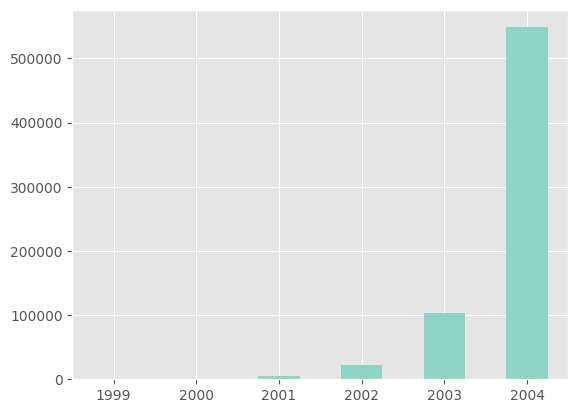

In [521]:
data = data_raw
data = data[data['year']!=',,']
data = data.loc[data.year.astype(int) < 2005,:]
data.year.value_counts().sort_index().plot(kind = 'bar', colormap='Set3')
plt.xticks(rotation=0, ha='center')


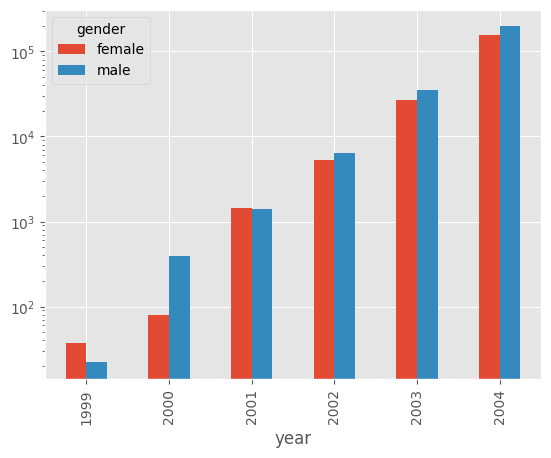

In [324]:
year_gender = data.pivot_table(index = 'year', columns = 'gender',values = 'author_id', aggfunc='count')
year_gender.plot(kind='bar', )
plt.yscale('log')

In [325]:
summary = data.groupby(['author_id','gender','age','occupation','sign'],as_index=False).agg({'blog_id':'count',
                                                                    'word_count':'sum'})
summary.head()

,author_id,gender,age,occupation,sign,blog_id,word_count
0,7596,male,26,Internet,Scorpio,14,2569
1,8349,male,24,Consulting,Cancer,70,3703
2,9289,male,23,Marketing,Taurus,89,24743
3,9470,male,25,Communications-Media,Aries,360,17920
4,11253,male,26,Technology,Aquarius,7,961


<AxesSubplot: xlabel='age'>

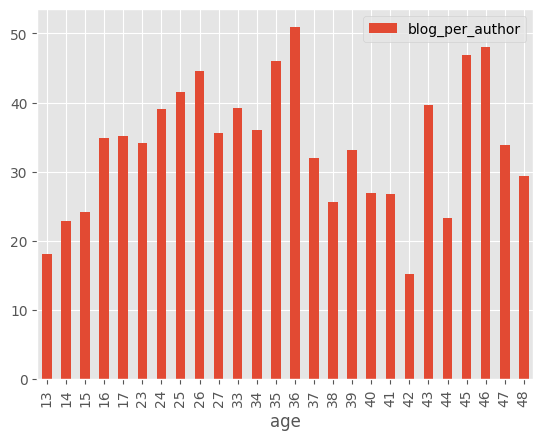

In [326]:
summary = summary.groupby('age', as_index=False).agg({'author_id':'count',
                            'blog_id':'sum',
                             })
summary.loc[:,'blog_per_author'] = summary['blog_id'] / summary['author_id']
summary.plot(x='age', y='blog_per_author', kind='bar')


### Connect to MySQL

In [ ]:
# IMPORT THE SQALCHEMY LIBRARY's CREATE_ENGINE METHOD
from sqlalchemy import create_engine

# DEFINE THE DATABASE CREDENTIALS
user = 'root'
password = 'password'
host = '127.0.0.1'
port = 3306
database = ''

# PYTHON FUNCTION TO CONNECT TO THE MYSQL DATABASE AND
# RETURN THE SQLACHEMY ENGINE OBJECT
def get_connection():
	return create_engine(
		url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
			user, password, host, port, database
		)
	)


if __name__ == '__main__':

	try:
		
		# GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
		engine = get_connection()
		print(
			f"Connection to the {host} for user {user} created successfully.")
	except Exception as ex:
		print("Connection could not be made due to the following error: \n", ex)


# Machine Learning

## Clean & encode raw data for fresh start

Due to computing power limit, set sample size for machine learning to 20000 for sentiment Analysis and Text Classification

In [385]:
data_raw = pd.read_csv('cleaned_text_dump.csv')
data_raw = data_raw[(data_raw['word_count']>5) & (data_raw['word_count']<200)]
data_raw = data_raw.dropna()
data_raw.loc[:,'gender'] = [1 if x =='female' else 0 for x in data_raw['gender']]
data_raw.loc[:,'age_coded'] = np.where(data_raw['age']<20,0,
                                 np.where(data_raw['age']<30,1,
                                 np.where(data_raw['age']<40,2,3)))
data_raw.reset_index(drop = True, inplace=True)
data_raw.shape

C:\Users\ykxio\AppData\Local\Temp\ipykernel_23940\2908821398.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_raw.loc[:,'gender'] = [1 if x =='female' else 0 for x in data_raw['gender']]


(268541, 14)

<AxesSubplot: >

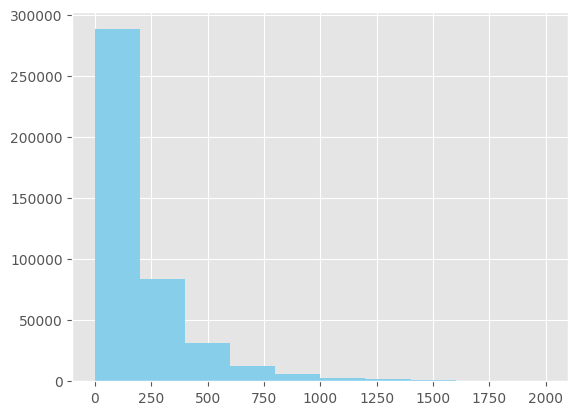

In [527]:
data.word_count.hist(color='skyblue', range = (0,2000))

## Sentiment Analysis

### Vader model

In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [384]:
data = data_ml_sm
text_1 = data.text[155]
text_2= data.text[5244]
text_3 = data.text[17126]
print(text_1,'\n\n' ,sia.polarity_scores(text_1))
print(text_2,'\n\n' , sia.polarity_scores(text_2))
print(text_3,'\n\n' , sia.polarity_scores(text_3))

                 Damn it's hump day.  I was listening to the raadio today and they were talking about this event they're having comming up called Kegs and Eggs.  It's a party from 8am-noon.  It sounds like a lot of fun, but it's on a friday.  It seems kinda messed up to take a whole day off just for a four hour party.  And it seems like the think that you may stumble home from not walk.  But Carbon Leaf is playing.  I'll think about it, it's a month from friday (2 days prior to Jender's Birthday).    On another note I just ran out of money (I mean until friday).  I kinda flipped out yesterday about it.  Then I realized I have another check before next rent.  It's just with these alimony payments now, I have to rebudget.  Yeah I know that's a lie, but I thought it was better than I spent $300 on a blanket and a pillow.  Sometimes I just have to give myself a knowing look and say: 'Where's your head at?'              

 {'neg': 0.027, 'neu': 0.847, 'pos': 0.127, 'compound': 0.9422}
     

In [115]:
res = {}
for i, row in data.iterrows():
    text = row['text']
    id = row['blog_id'] 
    res[id]=sia.polarity_scores(text)

In [116]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index':'blog_id'})
data_vader = vaders.merge(data, how='left')
data_vader.head()

,blog_id,neg,neu,pos,compound,author_id,gender,age,occupation,sign,date,text,word_count,year,clean_text,label_all,gender_age,age_coded
0,1000000,0.000,1.000,0.000,0.0000,2059027,0,15,Student,Leo,2004-05-14,"Info has been found (+/- 100 pages,...",28,2004,info find page mb pdf file wait untill team le...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
1,1000001,0.000,1.000,0.000,0.0000,2059027,0,15,Student,Leo,2004-05-13,These are the team members: Drewe...,20,2004,team member drewes van der laag urllink mail r...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
2,1000004,0.000,0.841,0.159,0.8805,3581210,0,33,InvestmentBanking,Aquarius,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...,65,2004,thank yahoo s toolbar capture url popup mean c...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
3,1000006,0.078,0.787,0.136,0.8929,3581210,0,33,InvestmentBanking,Aquarius,2004-06-10,Somehow Coca-Cola has a way of su...,196,2004,coca cola way sum thing early flagship jingle ...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
4,1000009,0.099,0.827,0.073,-0.5588,3581210,0,33,InvestmentBanking,Aquarius,2004-06-09,I surf the English news sites a l...,160,2004,surf english news site lot look tidbit korea f...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2


### Roberta

In [120]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [121]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
print('tokenizer finished')
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

tokenizer finished


In [118]:
def roberta_polarity(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    score_dict = {
        'roberta_neg': score[0],
        'roberta_neu':score[1],
        'roberta_pos':score[2]
    }
    return score_dict

In [366]:
print(text_1,'\n\n' ,sia.polarity_scores(text_1))
print(text_1,'\n\n' ,roberta_polarity(text_1))

                 Damn it's hump day.  I was listening to the raadio today and they were talking about this event they're having comming up called Kegs and Eggs.  It's a party from 8am-noon.  It sounds like a lot of fun, but it's on a friday.  It seems kinda messed up to take a whole day off just for a four hour party.  And it seems like the think that you may stumble home from not walk.  But Carbon Leaf is playing.  I'll think about it, it's a month from friday (2 days prior to Jender's Birthday).    On another note I just ran out of money (I mean until friday).  I kinda flipped out yesterday about it.  Then I realized I have another check before next rent.  It's just with these alimony payments now, I have to rebudget.  Yeah I know that's a lie, but I thought it was better than I spent $300 on a blanket and a pillow.  Sometimes I just have to give myself a knowing look and say: 'Where's your head at?'              

 {'neg': 0.027, 'neu': 0.847, 'pos': 0.127, 'compound': 0.9422}
     

In [386]:
print(text_2,'\n\n' ,sia.polarity_scores(text_2))
print(text_2,'\n\n' ,roberta_polarity(text_2))
print(text_3,'\n\n' ,sia.polarity_scores(text_3))
print(text_3,'\n\n' ,roberta_polarity(text_3))

       .............................................................................................. top five bad things that have happened to me in the last week. ..............................................................................................  (not in order of importance)  1. i sliced open my thumb on the severed edge of the top of a cream of celery soup can. lots of blood.  2. i haven't had time to schedule a haircut.  3. i didn't finish reading two papers by my friday class last week.  4. i forgot to bring some stuff into school for my wife earlier today.  5. something's wrong with my telephone at home.   What!?  Is it my fault that I've got a good life?  Did you *read* this blog last semester?  Last semester it sucked to be me.  I refuse to feel guilty for feeling ok about the world.   (i'm sure i just jinxed everything though.)  peace~     

 {'neg': 0.145, 'neu': 0.767, 'pos': 0.088, 'compound': -0.8788}
       .....................................................

In [ ]:
res = {}
for i, row in data.iterrows():
    try:            
        text = row['text']
        id = row['blog_id'] 
        vader_score =sia.polarity_scores(text)
        vader_score_rename = {}
        for key, value in vader_score.items():
            vader_score_rename[f'vader_{key}'] = value
        roberta_score = roberta_polarity(text)
        both = {**vader_score_rename, **roberta_score}
        res[id] = both
    except Exception as e:
        print(f'broke for {id} {e}')

In [375]:
result_both = pd.DataFrame(res).T
result_both = result_both.reset_index().rename(columns = {'index':'blog_id'})
result_both = result_both.merge(data, how='left')
result_both.head()

,blog_id,neg,neu,pos,compound,author_id,gender,age,occupation,sign,date,text,word_count,year,clean_text,label_all,gender_age,age_coded
0,1000000,0.000,1.000,0.000,0.0000,2059027,0,15,Student,Leo,2004-05-14,"Info has been found (+/- 100 pages,...",28,2004,info find page mb pdf file wait untill team le...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
1,1000001,0.000,1.000,0.000,0.0000,2059027,0,15,Student,Leo,2004-05-13,These are the team members: Drewe...,20,2004,team member drewes van der laag urllink mail r...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
2,1000004,0.000,0.841,0.159,0.8805,3581210,0,33,InvestmentBanking,Aquarius,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...,65,2004,thank yahoo s toolbar capture url popup mean c...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
3,1000006,0.078,0.787,0.136,0.8929,3581210,0,33,InvestmentBanking,Aquarius,2004-06-10,Somehow Coca-Cola has a way of su...,196,2004,coca cola way sum thing early flagship jingle ...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
4,1000009,0.099,0.827,0.073,-0.5588,3581210,0,33,InvestmentBanking,Aquarius,2004-06-09,I surf the English news sites a l...,160,2004,surf english news site lot look tidbit korea f...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2


In [32]:
result_both.to_csv("sentiment.csv", index= False)

### Visualization & analysis

In [378]:
result_both = pd.read_csv("sentiment.csv")
result_both.rename(columns={'reberta_pos':'roberta_pos'}, inplace=True)

In [379]:
result_both.loc[:,'year_month'] = result_both['date'].apply(lambda x : x[:7])
result_both.loc[:,'month'] = result_both['date'].apply(lambda x : x[5:7])

result_both.loc[:,'vader_cat'] = result_both['vader_compound'].apply(lambda x : 'positive' if x > 0 else ('neutral' if x == 0 else 'negative'))
result_both.loc[:,'roberta_cat'] = result_both[['roberta_neg','roberta_neu','roberta_pos']].idxmax(axis=1).\
                                apply(lambda x: 'positive' if x =='roberta_pos' else ('neutral' if x == 'roberta_neu' else 'negative'))

In [467]:
pd.set_option('display.max_columns', 30)
result_both[result_both['vader_cat']=='neutral'].head(3)

,blog_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,author_id,gender,age,occupation,sign,date,text,word_count,year,clean_text,label_all,gender_age,age_coded,year_month,month,vader_cat,roberta_cat
0,1000000,0.0,1.0,0.0,0.0,0.189991,0.621082,0.188927,2059027,0,15,Student,Leo,2004-05-14,"Info has been found (+/- 100 pages,...",28,2004,info find page mb pdf file wait untill team le...,"['male', '15', 'Student', 'Leo']","['male', '15']",0,2004-05,05,neutral,neutral
1,1000001,0.0,1.0,0.0,0.0,0.073389,0.862900,0.063711,2059027,0,15,Student,Leo,2004-05-13,These are the team members: Drewe...,20,2004,team member drewes van der laag urllink mail r...,"['male', '15', 'Student', 'Leo']","['male', '15']",0,2004-05,05,neutral,neutral
11,1000031,0.0,1.0,0.0,0.0,0.061930,0.687939,0.250130,3581210,0,33,InvestmentBanking,Aquarius,2004-06-29,urlLink The business class ta...,18,2004,urllink business class tag baggage pristine co...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2,2004-06,06,neutral,neutral


In [422]:
result_both.columns

Index(['blog_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'author_id', 'gender',
       'age', 'occupation', 'sign', 'date', 'text', 'word_count', 'year',
       'clean_text', 'label_all', 'gender_age', 'age_coded', 'year_month',
       'month', 'vader_cat', 'roberta_cat'],
      dtype='object')

In [178]:
# plot two plots, sentiment composition by month
# note that data was until aug 2004

result_both.head(10)
vaders = result_both[['month','vader_cat']]
roberta = result_both[['month','roberta_cat']]

Text(0.5, 1.0, 'Roberta Result')

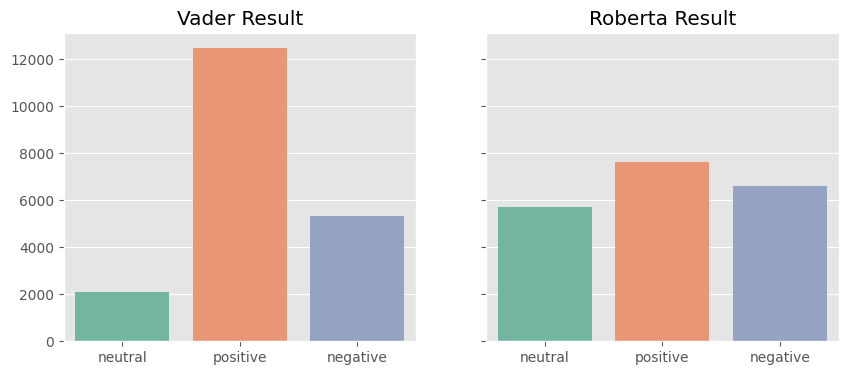

In [501]:

fig, axes = plt.subplots(1, 2, sharey=True, figsize = (10,4))
sns.countplot(ax = axes[0], x = vaders.vader_cat, palette='Set2')
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Vader Result')
sns.countplot(ax = axes[1],x = roberta.roberta_cat, palette='Set2')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Roberta Result')

Text(0.5, 1.0, 'Roberta Result')

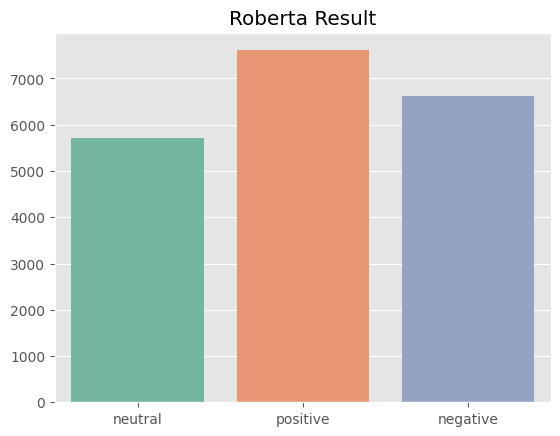

Text(0.5, 1.0, 'Sentiment Composition across year - Vader')

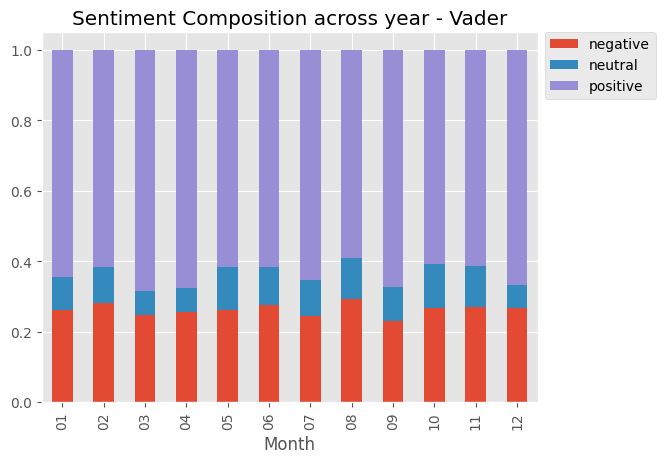

In [475]:
vaders_viz = vaders.groupby('month')['vader_cat']. value_counts(normalize=True).unstack('vader_cat')
vaders_viz.plot.bar(stacked = True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('Month')
plt.title('Sentiment Composition across year - Vader')

Text(0.5, 1.0, 'Sentiment Composition across year - Roberta')

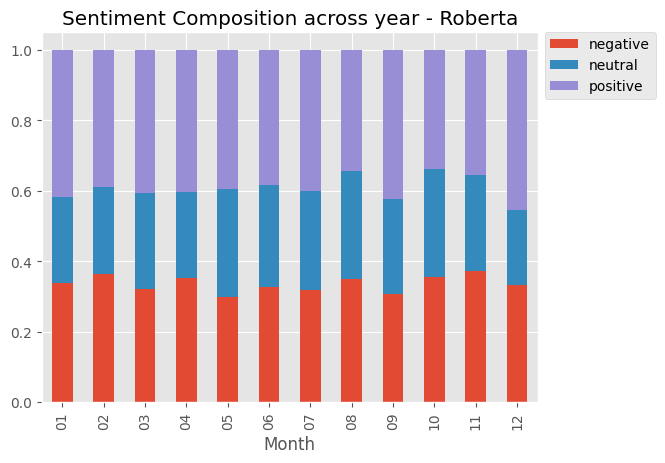

In [203]:
roberta_viz = roberta.groupby('month')['roberta_cat']. value_counts(normalize=True).unstack('roberta_cat')
roberta_viz.plot.bar(stacked = True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('Month')
plt.title('Sentiment Composition across year - Roberta')

Text(0.5, 1.0, 'Sentiment Composition by Zodiac - Vader')

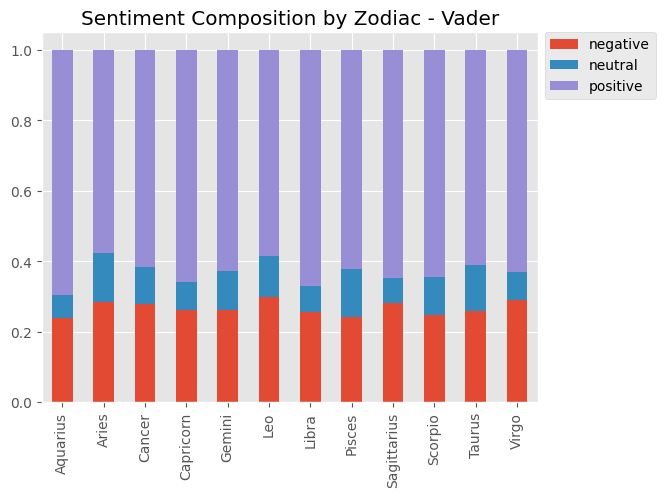

In [468]:
zodiac_va = result_both[['sign','vader_cat']]
zodiac_va.groupby('sign')['vader_cat'].value_counts(normalize=True).unstack().plot.bar(stacked=True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('')
plt.title('Sentiment Composition by Zodiac - Vader')

Text(0.5, 1.0, 'Sentiment Composition by Zodiac - Roberta')

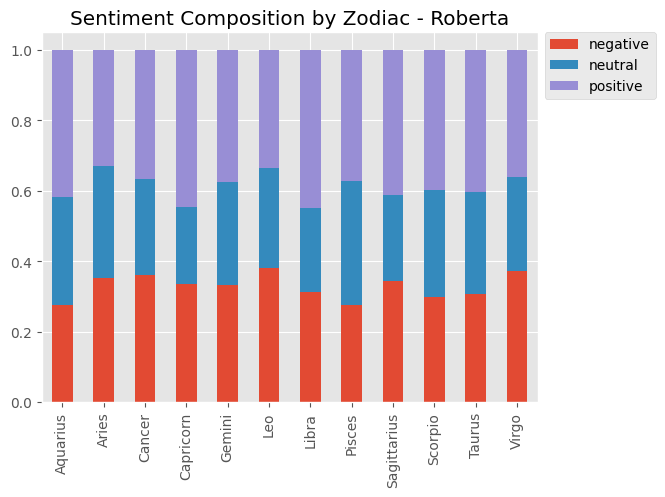

In [453]:
result_both.head()
zodiac_ro = result_both[['sign','roberta_cat']]
zodiac_ro.groupby('sign')['roberta_cat'].value_counts(normalize=True).unstack().plot.bar(stacked=True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('')
plt.title('Sentiment Composition by Zodiac - Roberta')

<AxesSubplot: xlabel='occupation'>

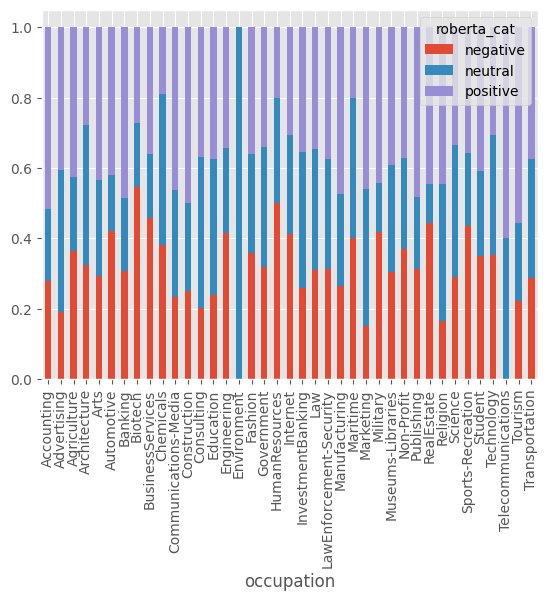

In [391]:
result_both.head()
job_ro = result_both[['occupation','roberta_cat']]
job_ro.groupby('occupation')['roberta_cat'].value_counts(normalize=True).unstack().plot.bar(stacked=True)

In [476]:
job_ro_clean = job_ro.groupby('occupation',as_index=False).count()
job_ro_clean = job_ro_clean[job_ro_clean['roberta_cat']>=20]
jobs = job_ro_clean.occupation.tolist()
# job_ro_clean

Text(0.5, 1.0, 'Sentiment Composition by Occupation - Roberta')

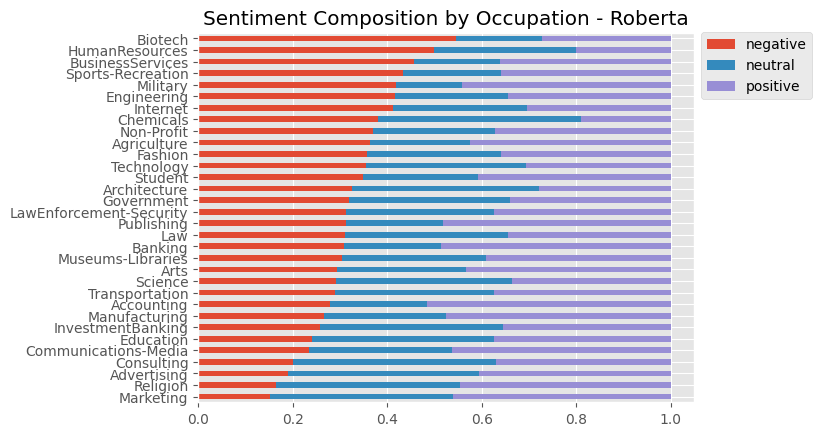

In [506]:
job_ro = job_ro[job_ro['occupation'].isin(jobs)]
job_ro.groupby('occupation')['roberta_cat'].value_counts(normalize=True).unstack().sort_values(by='negative').plot.barh(stacked=True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('')
plt.ylabel('')
plt.title('Sentiment Composition by Occupation - Roberta')

Text(0.5, 1.0, 'Sentiment Composition by Occupation - Vader')

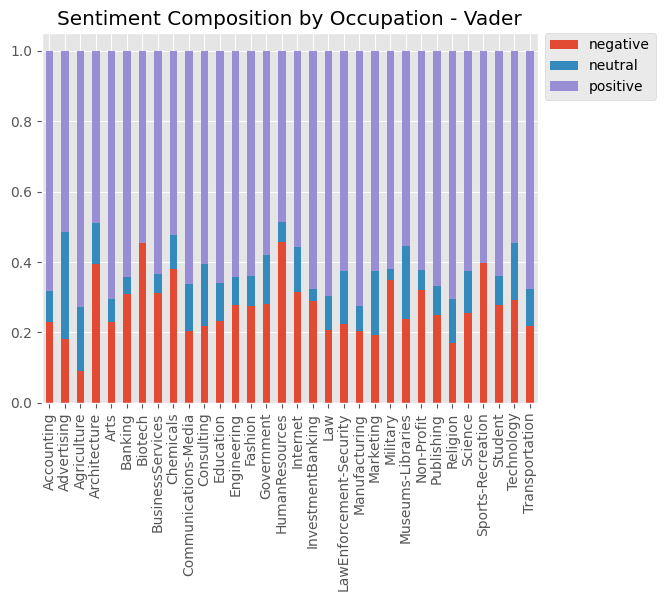

In [470]:
job_va = result_both[['occupation','vader_cat']]
job_va = job_va[job_va['occupation'].isin(jobs)]
job_va.groupby('occupation')['vader_cat'].value_counts(normalize=True).unstack().plot.bar(stacked=True)
plt.legend(
        bbox_to_anchor=(1, 1.02),
        loc="upper left"
    )
plt.xlabel('')
plt.title('Sentiment Composition by Occupation - Vader')

In [518]:
result_both.head()
pd.set_option('display.max_colwidth', 500)
result_both.loc[result_both['vader_cat']!=result_both['roberta_cat'],( 'text', 'vader_cat', 'roberta_cat')].head(20)


,text,vader_cat,roberta_cat
5,"There is so much that is different here from anything I've ever seen (well, I haven't travelled that much, just in Canada, the US, Philippines and Japan). And I mean totally different. Maybe it's because I've been here long enough to see a lot, I dunno. Anyways, if you'd like more on this place take a look at my urlLink Virtual Tourist pages .",positive,neutral
6,"urlLink Wonderful oh-gyup-sal at my favorite pork restaurant. It's official, pork has now outstripped beef as the top meat import to Korea. (See urlLink JoongAng Ilbo link ) and no wonder...what with Mad Cow Disease and Avian Flu virus going around. The only thing that seems 'safe' is pork. Of course, as you may know, oh-gyup-sal literally means 5 layers of fat...so maybe it's not super healthy. Well, I wasn't that bad, I did do 2 hours of inline skating (as they call ...",negative,neutral
10,"Koreans have a great sense of community. So much so that sometimes they figure they can have a nap any old place. Now I understand taking a snooze in a subway car (they are safer here) or taxi (done that a few times), but on some steps? Well, it happens. urlLink I couldn't resist taking a pic of this guy...it was like 6PM and he was already sacked out on the front steps of a building in Sinchon (teen district of Seoul). Notice his jacket is a step or so down from his re...",positive,neutral
19,"Man, how do I come across some of this stuff. Anyways, there are a couple things that may help get my buds over to Seoul sometime soon (you know who you are). Many have threatened to come here, and some read my blog and may be on the verge, but this should about do it. Here it is: urlLink Seoul, home of the sexiest women on the planet . (Not that they have a chance at meeting them, but they are in the city limits, apparently.) There's also the interesting theme parties they h...",positive,neutral
20,"Forgot I had this in my phone/camera. Actually got a series going of this dude at one of these dance video games. Think I remember seeing them in Vancouver too, but this ones is not just feet but arms. There are lasers or something that sense where and how he moves his arms and if it's in sync with the instructions/music. The guy was pretty thin and the moves made him look quite gay. I wonder if he does these kinds of actions on the dancefloor...I wouldn't if I were him, th...",positive,neutral
21,"Ok, it's not at all scientific. I was just taking a look through my millions of jpegs and such and found these two to be, well, eerily similar. urlLink DPRK's Kim Jong-il and U2's Bono Is it me? Or does urlLink North Korea 's (Democratic People's Republic of Korea/DPRK) 'Dear Leader' look at least a bit like urlLink U2 's Bono? Of course they have some pretty different ideas about human rights and the environment but I get the feeling that being in the public eye for s...",positive,neutral
22,"Man, with all that is going on I can see my posting to the ol' blog getting bogged down the next couple of week. Got a ton of stuff to do at work as well as the trip (at which time I'll be in full-Daddy mode for the duration) which means precious little time to blog. Well, we'll see how much I can relate to you from Canada. In the meantime, take a look at urlLink Shawn's blog . He's got some funny stuff to say usually, although lately he's been a little infatuated with taki...",positive,neutral
26,Such a boring day. I have no comments. I found out that I'm the shortest girl in my class. Had very healthy food today. I shall not mention what they are. Cos I can't be bothered to do so right now.,positive,negative
27,"Met up with Lim,Wilson,Roy and Theo for breakfast at Mac. I insisted want to go Mac cos wanted to play with food. So disgusting lor..Theo and I played with all the sauce. Mix honey,butter,sugar,coffee-mate,tomato ketchup,chilli sauce,coffee,milo and tartar sauce together. Fun but just gotta bear with the smell on our fingers after that. So fun to play with food. 17 ye

## Author Profiling

### Gender prediction

In [60]:
data = data_raw[:20000]
data.shape

(20000, 14)

In [396]:
data = data[['clean_text','gender']]
data.shape
data = data.dropna()
data.shape

(20000, 2)

#### Naive Bayes

In [433]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

X = data['clean_text']
vectorizer = CountVectorizer(max_features = 50000,stop_words='english', ngram_range=(1,3))
sparce_matrix = vectorizer.fit_transform(X)
X = sparce_matrix.astype(np.uint8).toarray()
y = data['gender'].astype(np.uint8)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      2421
           1       0.56      0.71      0.63      1579

    accuracy                           0.66      4000
   macro avg       0.66      0.67      0.66      4000
weighted avg       0.69      0.66      0.67      4000



#### Logistic Regression

In [ ]:
X = data['clean_text']
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
y = data['gender'].astype(np.uint8)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)
clf = LogisticRegression()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Logistic Regression accuracy for gender prediction: ',metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression accuracy for gender prediction:  0.75525
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2421
           1       0.74      0.59      0.66      1579

    accuracy                           0.76      4000
   macro avg       0.75      0.73      0.73      4000
weighted avg       0.75      0.76      0.75      4000



C:\Users\ykxio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [406]:
X = data['clean_text']
vectorizer = CountVectorizer(max_features = 50000, stop_words='english', ngram_range=(1,2))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)
clf = LogisticRegression()
clf.fit(x_train, y_train)
predicted = clf.predict(x_test)
print('Logistic Regression Accuracy: ',metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy:  0.7458


C:\Users\ykxio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Age prediction

#### ------------------- Start with clean data ! -------------------

In [431]:
data = data_raw[:20000]
data.head()

,author_id,gender,age,occupation,sign,blog_id,date,text,word_count,year,clean_text,label_all,gender_age,age_coded
0,2059027,0,15,Student,Leo,1000000,2004-05-14,"Info has been found (+/- 100 pages,...",28,2004,info find page mb pdf file wait untill team le...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
1,2059027,0,15,Student,Leo,1000001,2004-05-13,These are the team members: Drewe...,20,2004,team member drewes van der laag urllink mail r...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
2,3581210,0,33,InvestmentBanking,Aquarius,1000004,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...,65,2004,thank yahoo s toolbar capture url popup mean c...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
3,3581210,0,33,InvestmentBanking,Aquarius,1000006,2004-06-10,Somehow Coca-Cola has a way of su...,196,2004,coca cola way sum thing early flagship jingle ...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
4,3581210,0,33,InvestmentBanking,Aquarius,1000009,2004-06-09,I surf the English news sites a l...,160,2004,surf english news site lot look tidbit korea f...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2


#### Naive Bayes

In [434]:
X = data['clean_text']
vectorizer = CountVectorizer(max_features = 50000,stop_words='english', ngram_range=(1,3))
sparce_matrix = vectorizer.fit_transform(X)
X = sparce_matrix.astype(np.uint8).toarray()
y = data['age_coded'].astype(np.uint8)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
nb = GaussianNB()
y_pred = nb.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1469
           1       0.60      0.56      0.58      1466
           2       0.58      0.49      0.53       983
           3       0.18      0.22      0.20        82

    accuracy                           0.59      4000
   macro avg       0.49      0.50      0.49      4000
weighted avg       0.59      0.59      0.59      4000



#### Logistics Regression

In [435]:
X = data.clean_text
y = data.age_coded
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
vectorizer = CountVectorizer(max_features = 50000,stop_words='english', ngram_range=(1,3))
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

clf = LogisticRegression()
y_pred = clf.fit(x_train, y_train).predict(x_test)
print('Logistics Regression accuracy for age prediction: ', metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test, y_pred))


Logistics Regression accuracy for age prediction:  0.3095
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1469
           1       0.63      0.65      0.64      1466
           2       0.61      0.58      0.60       983
           3       0.45      0.16      0.23        82

    accuracy                           0.66      4000
   macro avg       0.60      0.53      0.55      4000
weighted avg       0.65      0.66      0.65      4000



C:\Users\ykxio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Topic analysis

In [4]:
data = data_raw 
data.head()

,author_id,gender,age,occupation,sign,blog_id,date,text,word_count,year,clean_text,label_all,gender_age,age_coded
0,2059027,0,15,Student,Leo,1000000,2004-05-14,"Info has been found (+/- 100 pages,...",28,2004,info find page mb pdf file wait untill team le...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
1,2059027,0,15,Student,Leo,1000001,2004-05-13,These are the team members: Drewe...,20,2004,team member drewes van der laag urllink mail r...,"['male', '15', 'Student', 'Leo']","['male', '15']",0
2,3581210,0,33,InvestmentBanking,Aquarius,1000004,2004-06-11,Thanks to Yahoo!'s Toolbar I can ...,65,2004,thank yahoo s toolbar capture url popup mean c...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
3,3581210,0,33,InvestmentBanking,Aquarius,1000006,2004-06-10,Somehow Coca-Cola has a way of su...,196,2004,coca cola way sum thing early flagship jingle ...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2
4,3581210,0,33,InvestmentBanking,Aquarius,1000009,2004-06-09,I surf the English news sites a l...,160,2004,surf english news site lot look tidbit korea f...,"['male', '33', 'InvestmentBanking', 'Aquarius']","['male', '33']",2


In [6]:
blog_10s = data[data['age_coded']==0]
blog_20s = data[data['age_coded']==1]
blog_30s = data[data['age_coded']==2]
blog_40s = data[data['age_coded']==3]

In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

[('like', 42847), ('know', 30604), ('think', 29811), ('day', 26592), ('good', 25767), ('time', 24108), ('today', 23307), ('thing', 20044), ('want', 19735), ('come', 17922), ('love', 16716), ('people', 16695), ('feel', 15100), ('ve', 14599), ('post', 13681), ('blog', 13372), ('oh', 12919), ('look', 12886), ('school', 12465), ('work', 12408), ('need', 11884), ('life', 11788), ('right', 11601), ('fun', 11455), ('new', 11152), ('tell', 10890), ('talk', 10739), ('way', 10633), ('friend', 10459), ('find', 9913), ('start', 9525), ('try', 9407), ('play', 9368), ('yeah', 9365), ('guy', 9316), ('night', 9210), ('bad', 9193), ('lol', 9077), ('home', 8827), ('leave', 8678), ('ok', 8631), ('read', 8591), ('write', 8571), ('mean', 8302), ('long', 8270), ('week', 8149), ('watch', 8078), ('year', 8017), ('hope', 7975), ('happy', 7822), ('little', 7806), ('great', 7786), ('stuff', 7751), ('haha', 7638), ('tomorrow', 7589), ('cool', 7523), ('maybe', 7325), ('let', 7282), ('guess', 7124), ('lot', 6995), 

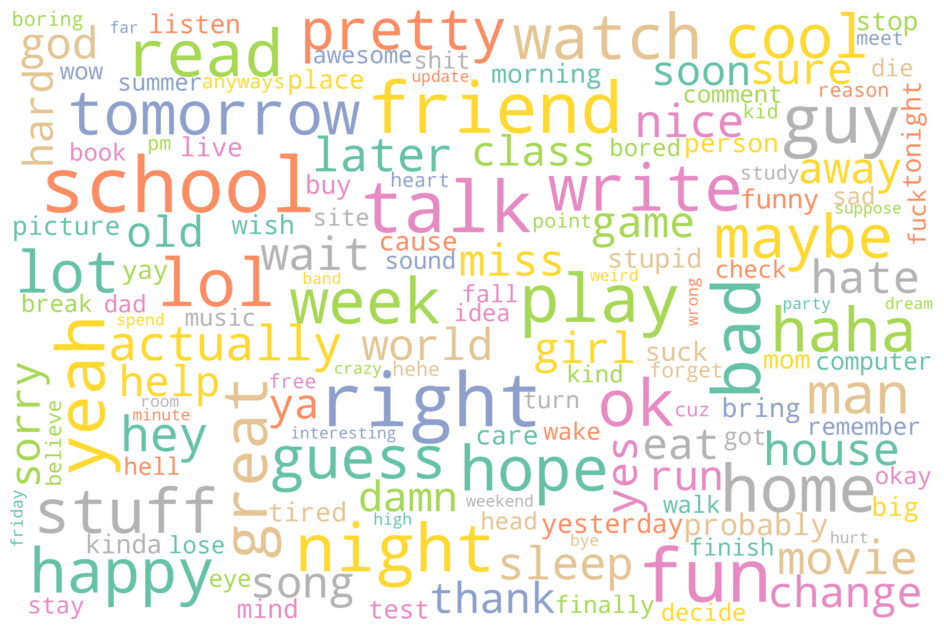

In [268]:
sentence_10s = blog_10s['clean_text'].tolist()
fdist_10s = FreqDist()
for sentence in sentence_10s:
    for word in word_tokenize(sentence):
        if word not in to_remove and len(word )>1:
            if word in fdist_10s.keys():
                fdist_10s[word] += 1
            else:
                fdist_10s[word] = 1

fdist_10s_raw = fdist_10s.most_common(100)
print(fdist_10s_raw)

vague_word_10s = ['like', 'know', 'think', 'day', 'today', 'good', 'time', 'thing', 'come', 'want', 
                  'need', 've','feel', 'look','find','word','tell','new','way','start','try', 'leave',
                   'mean', 'long', 'year', 'let','year','little','use','happen','end','hour', 'ask', 
                   'com', 'na','wan', 'yesderday', 'today', 'sit', 'hear', 'bit','post', 'oh' ,'love',
                   'work','life','people', 'blog','th']
for i in vague_word_10s:
    try:
        fdist_10s.pop(i)
    except KeyError:
        continue

from wordcloud import WordCloud
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2')
wordcloud.generate_from_frequencies(frequencies = fdist_10s)
plt.figure(figsize=(12,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

[('like', 37050), ('think', 30499), ('know', 29893), ('time', 29789), ('good', 27147), ('day', 26954), ('work', 24458), ('thing', 20998), ('want', 19239), ('today', 18850), ('come', 18798), ('ve', 18304), ('new', 18289), ('people', 17616), ('look', 16852), ('feel', 15385), ('love', 14457), ('night', 13520), ('find', 13216), ('post', 13174), ('need', 13077), ('blog', 12789), ('way', 12701), ('life', 12338), ('week', 12273), ('right', 12114), ('year', 12040), ('try', 11468), ('start', 11055), ('little', 10990), ('friend', 10920), ('use', 10542), ('read', 10450), ('great', 9810), ('tell', 9480), ('long', 9116), ('home', 8797), ('leave', 8612), ('let', 8594), ('guy', 8454), ('hope', 8425), ('man', 8262), ('bad', 8217), ('write', 8171), ('watch', 8140), ('lot', 8089), ('oh', 7960), ('maybe', 7569), ('play', 7534), ('mean', 7512), ('talk', 7449), ('com', 7372), ('old', 7277), ('world', 7162), ('sure', 6907), ('end', 6848), ('hour', 6800), ('pretty', 6799), ('big', 6709), ('place', 6707), ('w

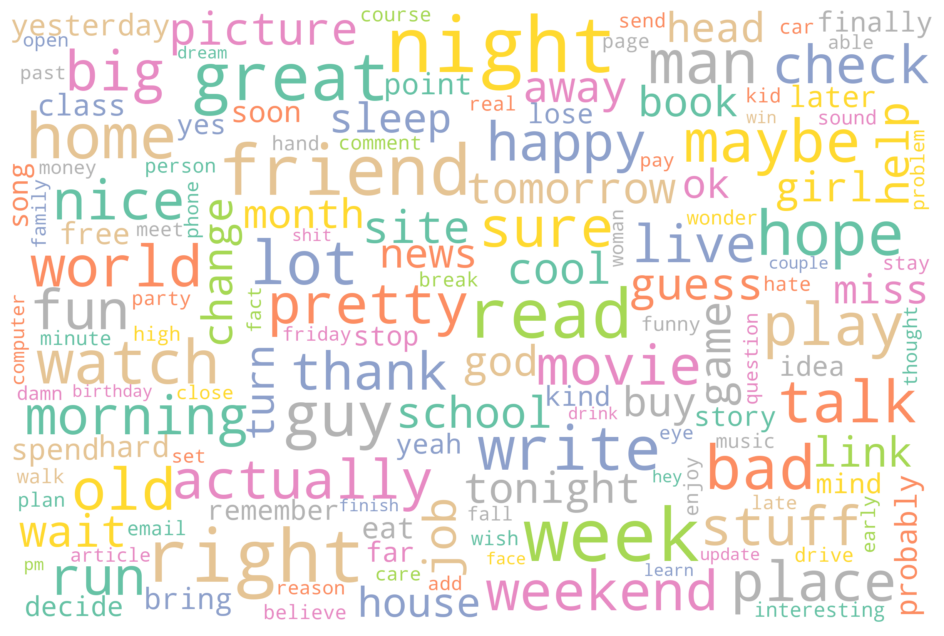

In [269]:
sentence_20s = blog_20s['clean_text'].tolist()
fdist_20s = FreqDist()
for sentence in sentence_20s:
    for word in word_tokenize(sentence):
        if word not in to_remove and len(word )>1:

            if word in fdist_20s.keys():
                fdist_20s[word] += 1
            else:
                fdist_20s[word] = 1

fdist_20s_raw = fdist_20s.most_common(100)
print(fdist_20s_raw)


vague_word = ['like', 'know', 'think', 'day', 'today', 'good', 'time', 'thing', 'come', 'want', 'need', 've','feel', 'look','find','word','tell','new','way','start','try', 'leave', 'mean', 'long', 'year',
              'let','year','little','use','happen','end','hour', 'ask', 'com', 'na','wan', 'yesderday', 'today', 'sit', 'hear', 'bit','post', 'oh' ,'love','work','life','people', 'blog','th']
for i in vague_word:
    try:
        fdist_20s.pop(i)
    except KeyError:
        continue
dict = fdist_20s.most_common(100)
print(dict)
from wordcloud import WordCloud
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2')
wordcloud.generate_from_frequencies(frequencies = fdist_20s)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

[('like', 7387), ('think', 6263), ('time', 6177), ('know', 5822), ('good', 5590), ('day', 5391), ('work', 5030), ('new', 4447), ('thing', 4095), ('look', 3975), ('want', 3841), ('come', 3783), ('today', 3777), ('people', 3694), ('ve', 3680), ('year', 3372), ('com', 2971), ('need', 2960), ('blog', 2958), ('love', 2921), ('find', 2865), ('way', 2837), ('post', 2814), ('use', 2800), ('feel', 2735), ('little', 2654), ('week', 2562), ('start', 2559), ('right', 2495), ('great', 2471), ('night', 2450), ('try', 2427), ('read', 2390), ('life', 2355), ('site', 2238), ('home', 2127), ('tell', 2089), ('friend', 2019), ('long', 1952), ('world', 1836), ('old', 1813), ('man', 1802), ('let', 1792), ('leave', 1708), ('write', 1705), ('play', 1612), ('hope', 1601), ('bad', 1560), ('mean', 1546), ('morning', 1535), ('news', 1526), ('lot', 1522), ('end', 1513), ('big', 1510), ('sure', 1480), ('guy', 1469), ('talk', 1465), ('run', 1450), ('watch', 1443), ('place', 1400), ('book', 1384), ('thank', 1374), ('

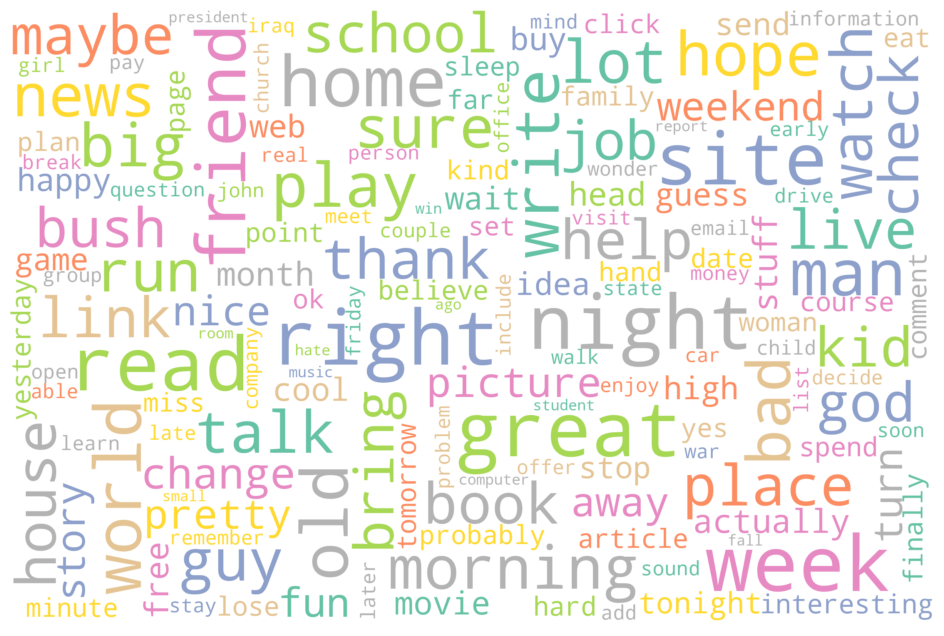

[('week', 2562), ('right', 2495), ('great', 2471), ('night', 2450), ('read', 2390), ('site', 2238), ('home', 2127), ('friend', 2019), ('world', 1836), ('old', 1813), ('man', 1802), ('write', 1705), ('play', 1612), ('hope', 1601), ('bad', 1560), ('morning', 1535), ('news', 1526), ('lot', 1522), ('big', 1510), ('sure', 1480), ('guy', 1469), ('talk', 1465), ('run', 1450), ('watch', 1443), ('place', 1400), ('book', 1384), ('thank', 1374), ('link', 1364), ('house', 1357), ('help', 1326), ('god', 1304), ('job', 1304), ('maybe', 1298), ('live', 1298), ('kid', 1289), ('school', 1287), ('bush', 1284), ('bring', 1283), ('check', 1274), ('change', 1249), ('picture', 1236), ('pretty', 1199), ('nice', 1198), ('away', 1191), ('fun', 1153), ('weekend', 1144), ('turn', 1141), ('story', 1138), ('actually', 1135), ('month', 1135), ('stuff', 1127), ('free', 1103), ('head', 1103), ('movie', 1076), ('cool', 1074), ('buy', 1061), ('wait', 1055), ('guess', 1044), ('web', 1043), ('high', 1039), ('happy', 1038

In [270]:
sentence_30s = blog_30s['clean_text'].tolist()

fdist_30s = FreqDist()
for sentence in sentence_30s:
    for word in word_tokenize(sentence):        
        if word not in to_remove and len(word )>1:

            if word in fdist_30s.keys():
                fdist_30s[word] += 1
            else:
                fdist_30s[word] = 1

fdist_30s_raw = fdist_30s.most_common(100)
print(fdist_30s_raw)


vague_word = ['like', 'know', 'think', 'day', 'today', 'good', 'time', 'thing', 'come', 'want', 'need', 've','feel', 'look','find','word','tell','new','way','start','try', 'leave', 'mean', 'long', 'year',
              'let','year','little','use','happen','end','hour', 'ask', 'com', 'na','wan', 'yesderday', 'today', 'sit', 'hear', 'bit','post', 'oh' ,'love','work','life','people', 'blog','th']

for i in vague_word:
    try:
        fdist_30s.pop(i)
    except KeyError:
        continue


dict = fdist_30s.most_common(100)
print(dict)
from wordcloud import WordCloud
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2')
wordcloud.generate_from_frequencies(frequencies = fdist_30s)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
fdist_30s.most_common(200)

[('like', 2326), ('time', 2276), ('day', 2204), ('think', 2027), ('know', 1981), ('good', 1890), ('work', 1778), ('new', 1676), ('look', 1489), ('today', 1474), ('thing', 1437), ('year', 1431), ('come', 1347), ('ve', 1322), ('people', 1308), ('want', 1297), ('find', 1215), ('blog', 1202), ('post', 1179), ('use', 1133), ('need', 1113), ('love', 986), ('way', 984), ('week', 975), ('feel', 961), ('right', 958), ('read', 939), ('life', 880), ('little', 869), ('news', 855), ('com', 852), ('site', 850), ('tell', 838), ('great', 835), ('try', 821), ('home', 776), ('long', 755), ('start', 754), ('night', 752), ('old', 747), ('link', 737), ('hope', 736), ('report', 707), ('world', 696), ('bush', 665), ('let', 642), ('write', 641), ('man', 630), ('morning', 621), ('leave', 604), ('lot', 604), ('page', 580), ('friend', 572), ('help', 571), ('run', 568), ('big', 563), ('bad', 548), ('picture', 546), ('live', 542), ('comment', 540), ('watch', 540), ('article', 535), ('thank', 528), ('story', 527), 

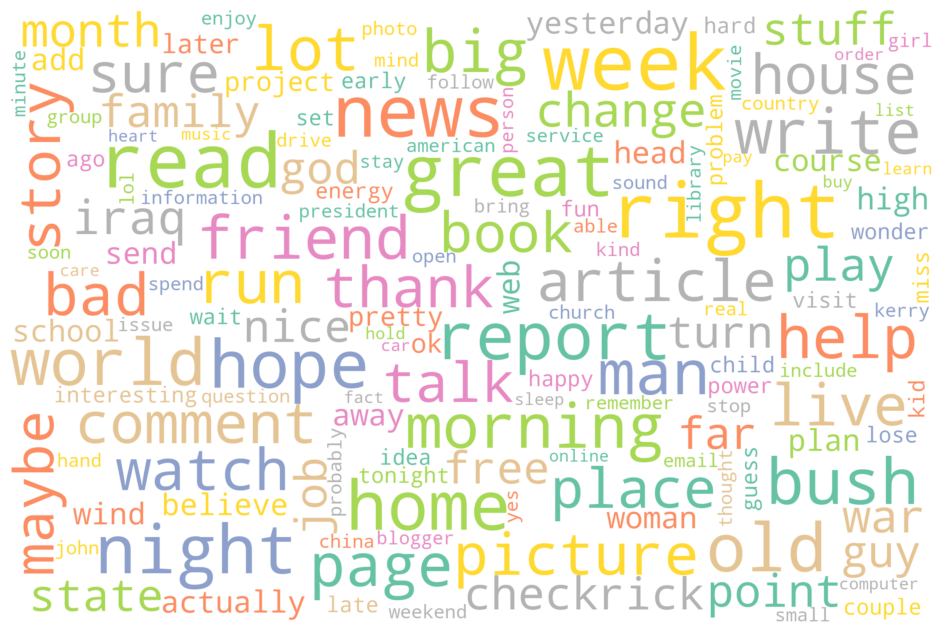

In [354]:
sentence_40s = blog_40s['clean_text'].tolist()

fdist_40s = FreqDist()
for sentence in sentence_40s:
    for word in word_tokenize(sentence):        
        if word not in to_remove and len(word )>1:

            if word in fdist_40s.keys():
                fdist_40s[word] += 1
            else:
                fdist_40s[word] = 1

fdist_40s_raw = fdist_40s.most_common(100)
print(fdist_40s_raw)

vague_word = ['like', 'know', 'think', 'day', 'today', 'good', 'time', 'thing', 'come', 'want', 'need', 've','feel', 'look','find','word','tell','new','way','start','try', 'leave', 'mean', 'long', 'year',
              'let','year','little','use','happen','end','hour', 'ask', 'com', 'na','wan', 'yesderday', 'tomorrow','today', 'sit', 'hear', 'bit','post', 'oh' ,'love','work','life','people', 'blog','th', 'link','site']

for i in vague_word:
    try:
        fdist_40s.pop(i)
    except KeyError:
        continue


dict = fdist_40s.most_common(100)
print(dict)
from wordcloud import WordCloud
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2',random_state=42)
wordcloud.generate_from_frequencies(frequencies = fdist_40s)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
sentence_male = data[data['gender']==0]['clean_text'].tolist()
sentence_female = data[data['gender']==1]['clean_text'].tolist()

In [274]:
fdist_male = FreqDist()
for sentence in sentence_male:
    for word in word_tokenize(sentence):
        if word not in to_remove and len(word )>1:
            if word in fdist_male.keys():
                fdist_male[word] += 1
            else:
                fdist_male[word] = 1

fdist_female = FreqDist()
for sentence in sentence_female:
    for word in word_tokenize(sentence):
        if word not in to_remove and len(word )>1:
            if word in fdist_female.keys():
                fdist_female[word] += 1
            else:
                fdist_female[word] = 1

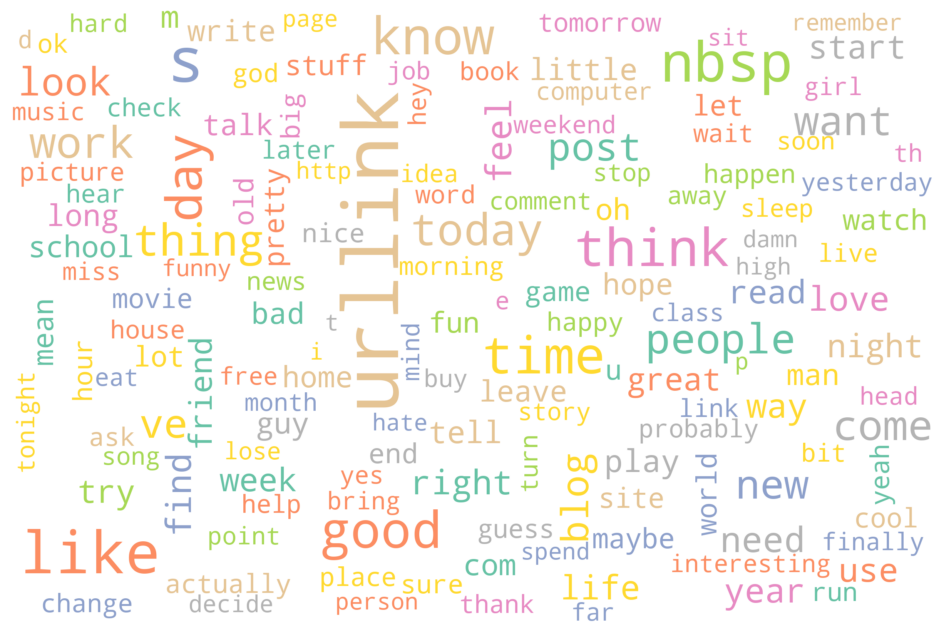

In [272]:
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2')
wordcloud.generate_from_frequencies(frequencies = fdist_male)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

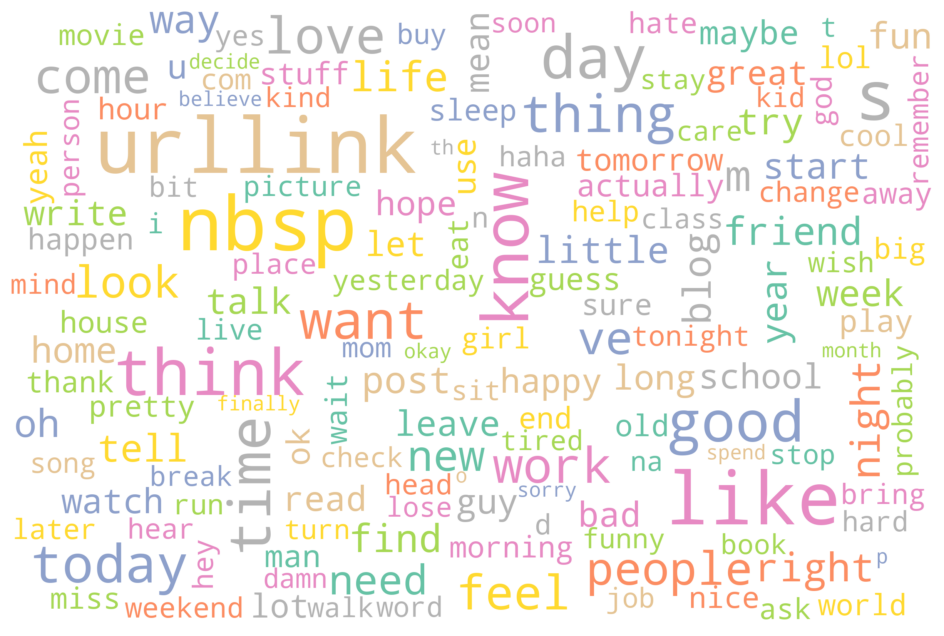

In [273]:
wordcloud = WordCloud(max_words = 150,max_font_size=200,background_color="white",width = 2400, height = 1600,colormap='Set2')
wordcloud.generate_from_frequencies(frequencies = fdist_female)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
fdist_female.most_common(200)

[('urllink', 48167), ('nbsp', 45587), ('like', 43139), ('s', 38759), ('know', 33088), ('think', 32687), ('day', 28473), ('time', 27022), ('good', 26155), ('want', 22391), ('today', 22002), ('thing', 21504), ('love', 20405), ('work', 19209), ('come', 19028), ('feel', 18054), ('people', 16750), ('ve', 16748), ('look', 15489), ('m', 14943), ('new', 14309), ('need', 13308), ('life', 13205), ('night', 12568), ('right', 12439), ('way', 12317), ('friend', 11934), ('oh', 11840), ('blog', 11817), ('find', 11760), ('tell', 11565), ('post', 11134), ('little', 10801), ('try', 10730), ('week', 10603), ('year', 10280), ('start', 10267), ('home', 10182), ('talk', 9877), ('fun', 9857), ('leave', 9417), ('read', 9155), ('bad', 9066), ('long', 8988), ('write', 8931), ('guy', 8861), ('school', 8812), ('let', 8613), ('watch', 8568), ('great', 8464), ('hope', 8452), ('happy', 8382), ('mean', 8375), ('u', 8104), ('maybe', 7839), ('lot', 7706), ('use', 7535), ('ok', 7378), ('yeah', 7100), ('man', 7058), ('to

### --------------------------------------- Trash -------------------------------------------